# Path Visualization and Optimization for AWS DeepRacer

In [185]:
from os import listdir
from os.path import isfile, join, exists, splitext

import math
import numpy as np

from scipy.interpolate import CubicSpline, BPoly

import pickle

import matplotlib
import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets

# matplotlib.use('webagg')

%matplotlib notebook

matplotlib.rcParams['savefig.dpi'] = 60
matplotlib.rcParams['figure.dpi'] = 60

## Load waypoints for the track you want to run analysis on

In [32]:
tracks = [splitext(f)[0] for f in listdir("tracks/") if isfile(join("tracks/", f))]

print(tracks)

['Oval_track', 'ChampionshipCup2019_track', 'New_York_Track', 'Mexico_track', 'Tokyo_Training_track', 'reinvent_base', 'H_track', 'Bowtie_track', 'reInvent2019_track', 'China_track', 'Canada_Training', 'reInvent2019_wide', 'AWS_track', 'London_Loop_Train', 'reInvent2019_wide_mirrored', 'Virtual_May19_Train_track', 'Straight_track', 'Vegas_track']


In [264]:
def wrap_360(theta):
    theta = theta % 360;
    theta = (theta + 360) % 360
    
    return theta


def wrap_180(theta):
    theta = wrap_360(theta)
    if theta > 180:
        theta -= 360

    return theta


def convert_slope(m):
    radians = math.atan2(m[1], m[0])
    dir1 = radians
    dir2 = (radians + np.pi) % (2 * np.pi)
    
    return [dir1, dir2]


def get_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


# def get_angle(l1, l2):
#     d1x = l1[1][0] - l1[0][0]
#     d1y = l1[1][1] - l1[0][1]
#     d2x = l2[1][0] - l2[0][0]
#     d2y = l2[1][1] - l2[0][1]
    
#     return math.atan2(d1x * d2y - d1y * d2x, d1x * d2x + d1y * d2y)


# def get_spline(points, centerpoint):
#     x = points[:,0]
#     y = points[:,1]

#     x_min = min(x)    
#     x = x - x_min
    
#     theta = get_periodic(list(zip(x, y)), centerpoint)
#     theta[0] = 0
    
#     return CubicSpline(theta, points, bc_type='periodic')


# def get_points(cs, num=250):
#     xs = 2 * np.pi * np.linspace(0, 1, num)
#     return cs(xs)


# def get_periodic(points, centerpoint):
#     value = []
#     l1 = (centerpoint, (centerpoint[0]+1, centerpoint[1]))
    
#     for point in points:
#         l2 = (centerpoint, point)
#         value.append(get_angle(l1, l2) + np.pi)
        
#     return value


def get_nearest_point(waypoints, point):
    min_i = None
    min_distance = math.inf

    for i, waypoint in enumerate(waypoints):
        distance = get_distance(waypoint, point)
        if distance < min_distance:
            min_i = i
            min_distance = distance
    
    return min_i


def get_best_position(waypoints, point):
    i1 = get_nearest_point(waypoints, point)
    p1 = waypoints[i1]
    
    i2 = i1 + 1
    if i2 > len(waypoints)-1:
        i2 = 0

    p2 = waypoints[i2]
    
    m = [p2[0] - p1[0], p2[1] - p1[1]]
    
    return p1, m


def plot_way(ax, waypoints, controlpoints):
    x = waypoints[:,0]
    y = waypoints[:,1]
    x2 = controlpoints[:,0]
    y2 = controlpoints[:,1]
    
    ax.scatter(x2, y2, s=60, color="black")
    ax.plot(x, y, color="skyblue")
    ax.scatter(x, y, s=20, alpha=.25, color="skyblue")


def plot_cubic_spline(ax, controlpoints, tangents, samples):
    ax.plot(samples[:,0], samples[:,1])
    ax.scatter(samples[:,0], samples[:,1], marker='o', label='samples')
    ax.scatter(controlpoints[:,0], controlpoints[:,1], s=100, c='k', label='input')

    
def plot_slope(ax, point, slope, color="black"):
    x = point[0]
    y = point[1]
    
    rads = convert_slope(slope)[0]
    cos = np.cos(rads)
    
    slope = slope[1]/slope[0]
    
    b = y - (slope * x)
    xs = np.array([x-cos*.75, x+cos*.75])
    ys = (slope * xs) + b
    
    ax.plot(xs, ys, color=color)
    
    
def plot_best_position(ax, current_position, best_position, slope):
    positions = np.array([current_position, position])
    plot_waypoints(ax, positions, s=80, color="black")
    plot_slope(ax, position, slope)
    ax.plot(positions[:,0], positions[:,1], linestyle='dashed')

    
def plot_track_waypoints(ax, points):
    x = points[:,0]
    y = points[:,1]
    ax.plot(x, y, linewidth=5, alpha=.25)
    
    
def plot_track(ax, track_waypoints):
    plot_track_waypoints(ax, track_waypoints[:,0:2])
    plot_track_waypoints(ax, track_waypoints[:,2:4])
    plot_track_waypoints(ax, track_waypoints[:,4:6])

In [348]:
def cubic_spline_samples(points, tangents, scales, resolution):
    '''
    Compute and sample the cubic splines for a set of input points with
    optional information about the tangent (direction AND magnitude). The 
    splines are parametrized along the traverse line (piecewise linear), with
    the resolution being the step size of the parametrization parameter.
    The resulting samples have NOT an equidistant spacing.

    Arguments:      points: a list of n-dimensional points
                    tangents: a list of tangents
                    resolution: parametrization step size
    Returns:        samples

    Notes: Lists points and tangents must have equal length. In case a tangent
           is not specified for a point, just pass None. For example:
                    points = [[0,0], [1,1], [2,0]]
                    tangents = [[1,1], None, [1,-1]]

    '''
    resolution = float(resolution)
    points = np.asarray(points)
    num_points, dim = points.shape

    # parametrization parameter s.
    dp = np.diff(points, axis=0)                 # difference between points
    dp = np.linalg.norm(dp, axis=1)              # distance between points
    d = np.cumsum(dp)                            # cumsum along the segments
    d = np.hstack([[0], d])                      # add distance from first point
    l = d[-1]                                    # length of point sequence
    num_samples = int(l/resolution)              # number of samples
    s, r = np.linspace(0, l, num_samples, retstep=True) # sample parameter and step

    # Bring points and (optional) tangent information into correct format.
    assert(len(points) == len(tangents))
    
    data = np.empty([num_points, dim], dtype=object)
    
    for i, p in enumerate(points):
        t = tangents[i]
        scale = scales[i]
        
        if not t is None and not scale is None:
            t = np.multiply(t, scale)
            
        # either tangent is None or has the same
        # number of dimensions as the point p.
        assert(t is None or len(t) == dim)
        fuse = list(zip(p, t) if t is not None else zip(p,))
        data[i, :] = fuse

    # compute splines per dimension separately.
    samples = np.zeros([num_samples, dim])
    
    for i in range(dim):
        poly = BPoly.from_derivatives(d, data[:, i])
        samples[:, i] = poly(s)

    return samples

In [278]:
def get_track_waypoints(track):
    return np.load("./tracks/%s.npy" % track)

## Choose Control Points for re:Invent Track

<IPython.core.display.Javascript object>


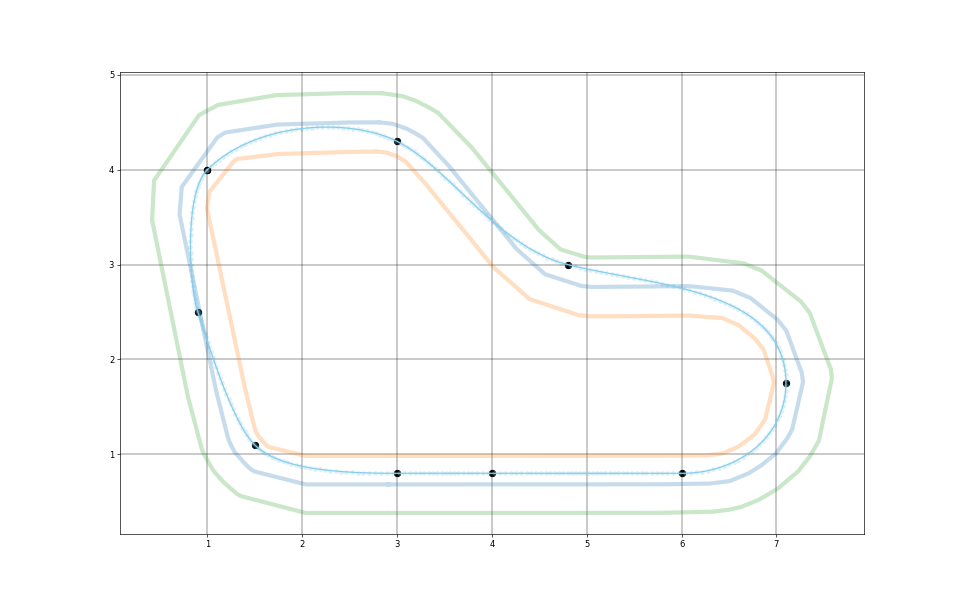

In [373]:
track = "reinvent_base"

track_waypoints = get_track_waypoints(track)
track_waypoints.shape 

points = []
tangents = []
scales = []

points.append([1., 4.]); tangents.append([1, 1]); scales.append(.75)
points.append([3., 4.3]); tangents.append([1, -.5]); scales.append(.75)
points.append([4.8, 3.]); tangents.append([1, -.25]); scales.append(1)
points.append([7.1, 1.75]); tangents.append([0, -1]); scales.append(1.15)
points.append([6, .8]); tangents.append([-1, 0]); scales.append(1.25)
points.append([4, .8]); tangents.append([-1, 0]); scales.append(1.25)
points.append([3, .8]); tangents.append([-1, 0]); scales.append(1.25)
points.append([1.5, 1.1]); tangents.append([-1, 1]); scales.append(.5)
points.append([.9, 2.5]); tangents.append([-.35, 1]); scales.append(.5)
points.append([1., 4.]); tangents.append([1, 1]); scales.append(.5)

points = np.array(points)
tangents = np.array(tangents)
scales = np.array(scales)

waypoints = cubic_spline_samples(points, tangents, scales, .05)

# print(waypoints.tolist())

# Plot the results
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_track(ax, track_waypoints)
plot_way(ax, waypoints, points)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

## Visualize Nearest Point

<IPython.core.display.Javascript object>


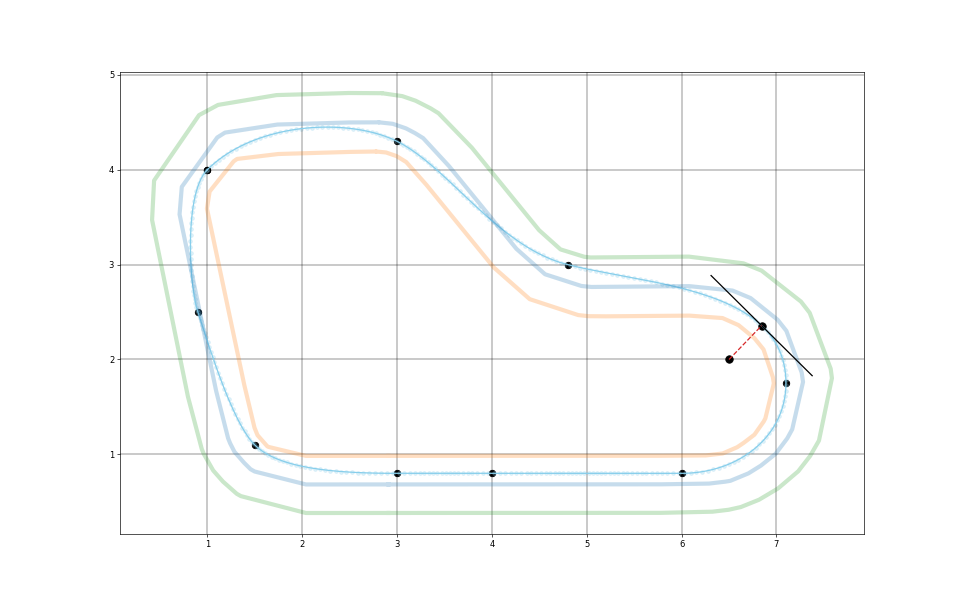

In [281]:
current_position = [6.5, 2]

position, slope = get_best_position(waypoints, current_position)
 
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_way(ax, waypoints, points)
plot_track(ax, track_waypoints)

plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)

plt.show()

## Visualize Headings

<IPython.core.display.Javascript object>


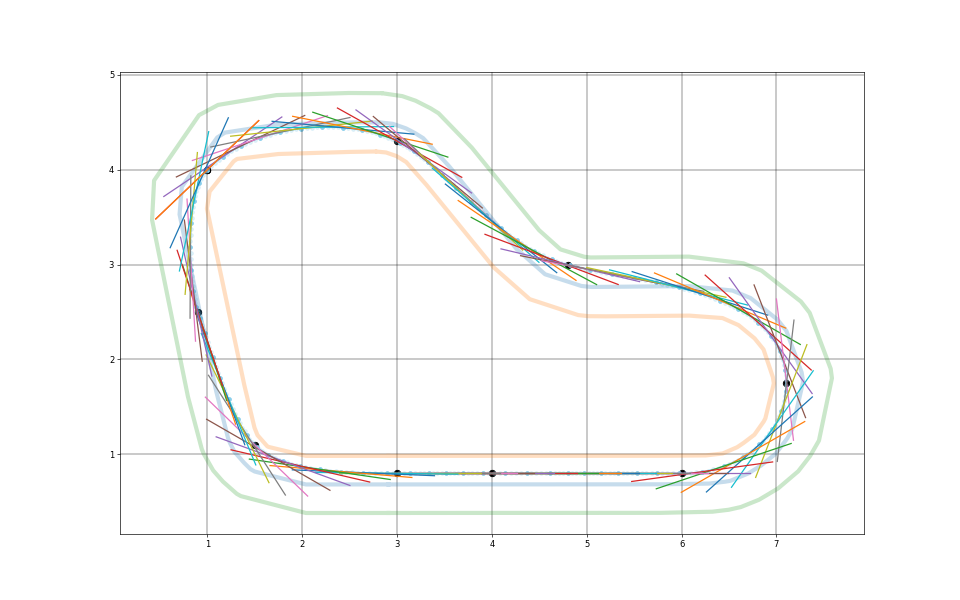

In [282]:
positions = cubic_spline_samples(points, tangents, scales, .2)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_way(ax, waypoints, points)
plot_track(ax, track_waypoints)

for position in positions:
    position, slope = get_best_position(waypoints, position)
    plot_slope(ax, position, slope, color=None)
    plot_waypoints(ax, np.array([position]), color="skyblue")

plt.grid(color='black', linestyle='-', linewidth=.5)

plt.show()

## Visualize Reward Function

<IPython.core.display.Javascript object>


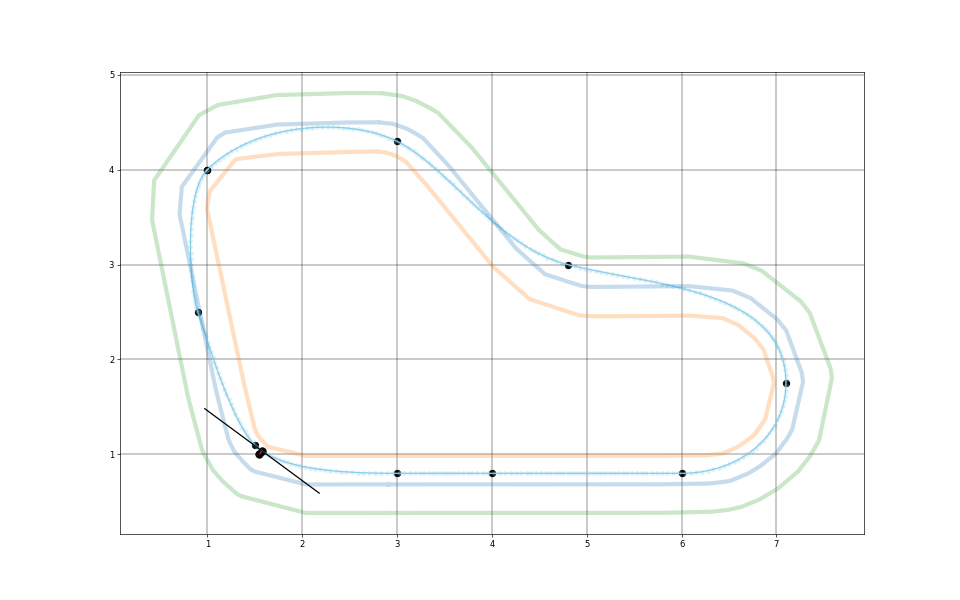

Params: {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': 5.647574749103853, 'x': 1.55, 'y': 1}
Heading: 5.647574749103853
Best Position: [1.57705928 1.03622196]
Best Headings: [143.5821976083069, 323.58219760830684]
Difference from Best Position: 0.04521321251944171
Difference from Best Heading: 137.93462285920305
Position Reward: 3.821311736334007
Heading Reward: 2.614198327670202
Reward: 99.79344178866005


<IPython.core.display.Javascript object>


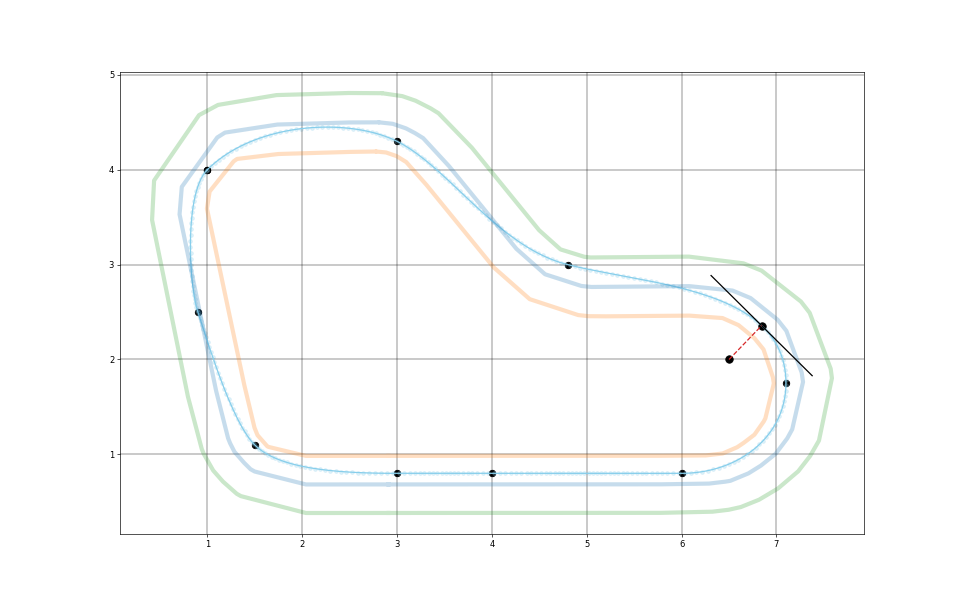

Params: {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': 2.3608382462946906, 'x': 6.5, 'y': 2}
Heading: 2.3608382462946906
Best Position: [6.8435653  2.35712111]
Best Headings: [315.266067625751, 135.26606762575102]
Difference from Best Position: 0.49555282414019536
Difference from Best Heading: 132.90522937945633
Position Reward: 2.37587540503662
Heading Reward: 2.659569982175839
Reward: 39.92732074849029


<IPython.core.display.Javascript object>


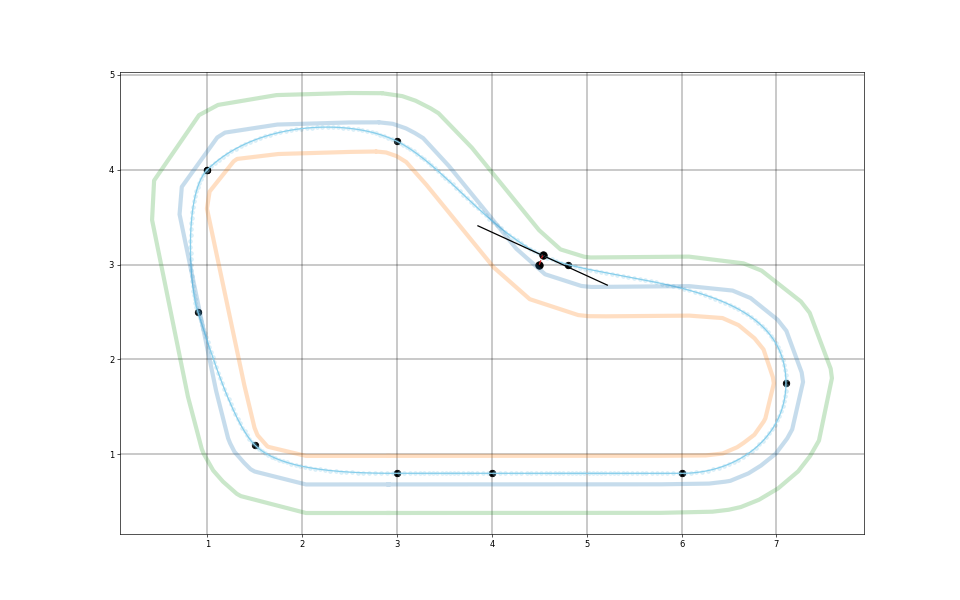

Params: {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': 30, 'x': 4.5, 'y': 3}
Heading: 30
Best Position: [4.53509162 3.096563  ]
Best Headings: [335.3779218567124, 155.37792185671242]
Difference from Best Position: 0.1027415904393527
Difference from Best Heading: 125.37792185671242
Position Reward: 3.6009555821004393
Heading Reward: 2.7282053689463117
Reward: 96.51385155383811


<IPython.core.display.Javascript object>


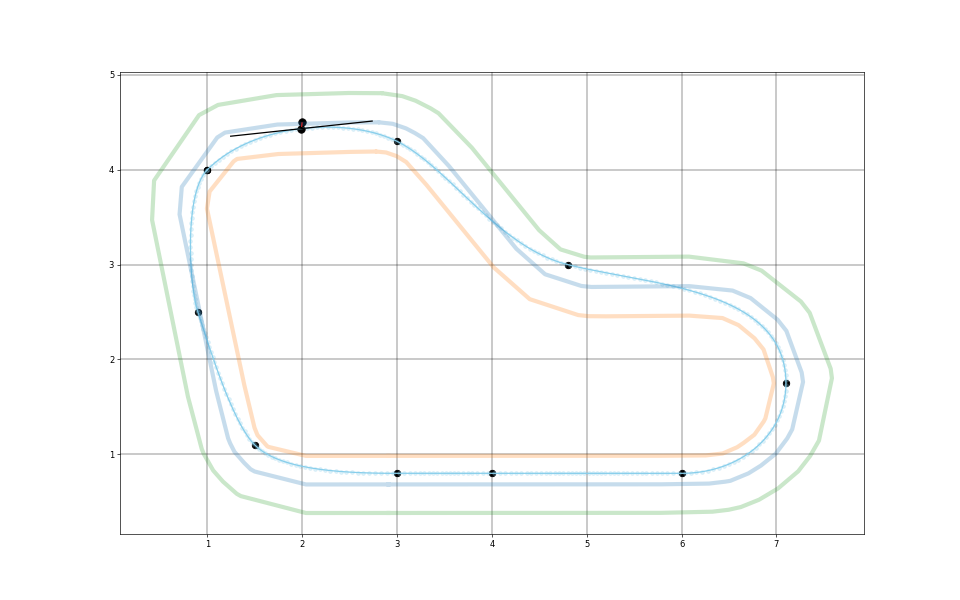

Params: {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': -140, 'x': 2, 'y': 4.5}
Heading: 220
Best Position: [1.99251734 4.43351453]
Best Headings: [6.107416120429434, 186.10741612042943]
Difference from Best Position: 0.06690521234618726
Difference from Best Heading: 33.892583879570566
Position Reward: 3.73724073767925
Heading Reward: 3.632279216477254
Reward: 184.2725305456555


184.2725305456555

In [283]:
def get_test_params(position, heading):
    return {
        # known good values
        'all_wheels_on_track': True,
        'track_width': .4,
        'is_reversed': False,
        'distance_from_center': .045,

        'heading': heading,
        'x': position[0],
        'y': position[1]
    }

def reward_function(params):
    # Read input parameters
    print('Params:', params)
    
    is_reversed = params['is_reversed']
    all_wheels_on_track = params['all_wheels_on_track']
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    heading = params['heading']
    x = params['x']
    y = params['y']

    heading = wrap_360(heading)
    
    print("Heading:", heading)
    
    position = [x, y]
    
    # Give a very low reward by default
    reward = 1e-3

    best_position, slope = get_best_position(waypoints, [x, y])
    best_headings = [wrap_360(math.degrees(direction)) for direction in convert_slope(slope)]

    print("Best Position:", best_position)
    print("Best Headings:", best_headings)
    
    best_position_diff = get_distance(position, best_position)
    best_heading_diff = min([abs(heading - best_heading) for best_heading in best_headings])
    
    print("Difference from Best Position:", best_position_diff)
    print("Difference from Best Heading:", best_heading_diff)

    # Give a high reward if no wheels go off the track and
    # the agent is somewhere in between the track borders
    if not is_reversed and all_wheels_on_track and (0.5*track_width - distance_from_center) >= 0.05:
        reward = 1.0

    position_reward = (1 + (1 - math.tanh(best_position_diff))) ** 2
    heading_reward = (1 + (1 - best_heading_diff / 360)) ** 2
    reward *= (position_reward * heading_reward) ** 2
    
    print("Position Reward:", position_reward)
    print("Heading Reward:", heading_reward)    
    print("Reward:", reward)

    # Always return a float value
    return float(reward)


####################################### position 1 #######################################

current_position = [1.55, 1]
position, slope = get_best_position(waypoints, current_position)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_way(ax, waypoints, points)
plot_track(ax, track_waypoints)
plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

reward_function(get_test_params(current_position, wrap_180(convert_slope(slope)[1])))


####################################### position 2 #######################################

current_position = [6.5, 2]
position, slope = get_best_position(waypoints, current_position)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_way(ax, waypoints, points)
plot_track(ax, track_waypoints)
plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

reward_function(get_test_params(current_position, wrap_180(convert_slope(slope)[1])))


####################################### position 3 #######################################

current_position = [4.5, 3]
position, slope = get_best_position(waypoints, current_position)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_way(ax, waypoints, points)
plot_track(ax, track_waypoints)
plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

reward_function(get_test_params(current_position, 30))


####################################### position 4 #######################################

current_position = [2, 4.5]
position, slope = get_best_position(waypoints, current_position)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_way(ax, waypoints, points)
plot_track(ax, track_waypoints)
plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

reward_function(get_test_params(current_position, -140))

## Choose Control Points for re:Invent 2019 Track

<IPython.core.display.Javascript object>


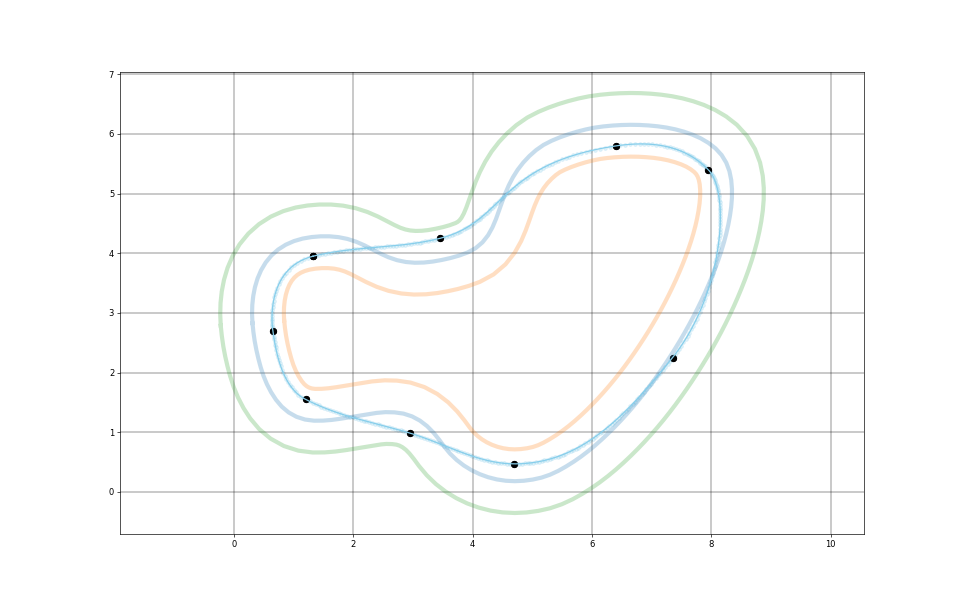

In [377]:
track = "reInvent2019_track"

track_waypoints = get_track_waypoints(track)
track_waypoints.shape 

points = []
tangents = []
scales = []

points.append([1.32, 3.95]); tangents.append([1, .25]); scales.append(1)
points.append([3.45, 4.25]); tangents.append([1, .25]); scales.append(1)
points.append([6.4, 5.8]); tangents.append([1, .15]); scales.append(1.8)
points.append([7.95, 5.4]); tangents.append([1, -1]); scales.append(.35)
points.append([7.35, 2.25]); tangents.append([-.8, -1]); scales.append(1)
points.append([4.7, .47]); tangents.append([-1, 0]); scales.append(1)
points.append([2.95, 0.985]); tangents.append([-1, .3]); scales.append(1)
points.append([1.2, 1.55]); tangents.append([-1, .5]); scales.append(1)
points.append([.65, 2.7]); tangents.append([-.15, 1]); scales.append(.6)
points.append([1.32, 3.95]); tangents.append([1, .25]); scales.append(1.5)

points = np.array(points)
tangents = np.array(tangents)
scales = np.array(scales)

waypoints = cubic_spline_samples(points, tangents, scales, .05)

# print(waypoints.tolist())

# Plot the results
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_track(ax, track_waypoints)

plot_way(ax, waypoints, points)
plot_waypoints(ax, points, s=50, color="black")

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

# Visualize Nearest Point

<IPython.core.display.Javascript object>


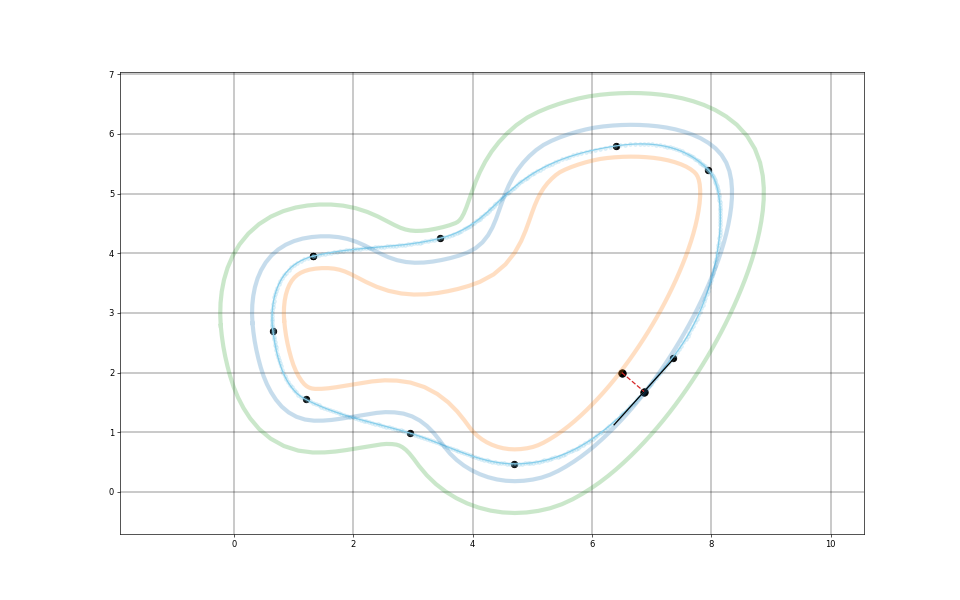

In [370]:
current_position = [6.5, 2]

position, slope = get_best_position(waypoints, current_position)
 
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_way(ax, waypoints, points)
plot_track(ax, track_waypoints)

plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)

plt.show()

## Visualize Headings

<IPython.core.display.Javascript object>


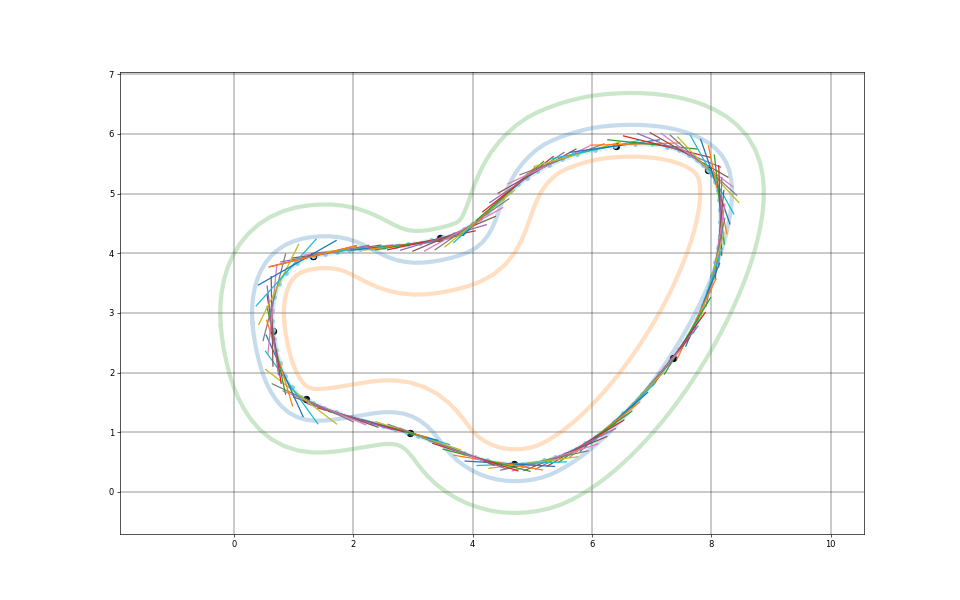

In [371]:
positions = cubic_spline_samples(points, tangents, scales, .2)

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('equal')

plot_way(ax, waypoints, points)
plot_track(ax, track_waypoints)

for position in positions:
    position, slope = get_best_position(waypoints, position)
    plot_slope(ax, position, slope, color=None)
    plot_waypoints(ax, np.array([position]), color="skyblue")

plt.grid(color='black', linestyle='-', linewidth=.5)

plt.show()